In [1]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xilverh0ya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [9]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

### 1. 데이터 적재

In [16]:
df = pd.read_csv("D:/DataSet/Natural Language Processing with Disaster Tweets/train.csv")

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### 01. 'text_len' Column 생성
- 트윗을 단어 단위로 분리했을 때, 몇개의 단어로 구성되어 있는 지 표시

In [25]:
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df['text_len'].describe()

count    7613.000000
mean       14.928937
std         5.782770
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: text_len, dtype: float64

In [18]:
max(df['text_len'])

54

### 2. EDA와 전처리

#### 01. 타겟값의 균형성 확인

In [19]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271], dtype=int64)

In [28]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham(1)'],
    y=[balance_counts[0]],
    name='ham(1)',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam(0)'],
    y=[balance_counts[1]],
    name='spam(0)',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

* spam > ham : 1071개 차이

#### 02. 트윗 텍스트 정제

- 각종 함수를 통해 정제하기 전, 간단한 전처리를 통해 '깔끔한' 텍스트로 변환한다.

In [29]:
# refer https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
        
    text = str(text).lower() # 1. 텍스트를 모두 소문자로 변환
    text = re.sub('\[.*?\]', '', text) # 2. 대괄호 안에 있는 텍스트 삭제
    text = re.sub('https?://\S+|www\.\S+', '', text) # 3. 링크 삭제
    text = re.sub('<.*?>+', '', text) # 브라켓 안에 있는 텍스트 삭제
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # 4. 구두점 삭제
    text = re.sub('\n', '', text) # 5. 개행 삭제
    text = re.sub('\w*\d\w*', '', text) # 6. 숫자를 포함한 단어 삭제
    return text

In [30]:
df['text_clean'] = df['text'].apply(clean_text)
df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,just got sent this photo from ruby alaska as s...


- Stopwords 제거  
    <br>
    - Stopword는 문장에서 문맥적 의미가 없는 영어에서 일반적으로 사용되는 단어입니다.  
    <br>
    - 분류 전에 제거

In [31]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['text_clean'] = df['text_clean'].apply(remove_stopwords)
df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo ruby alaska smoke wildfires pou...


##### 형태소 분석 / 표제어화 (Stemming / Lematization)  
- 같은 의미지만 다른 형태를 띄는 단어들 존재  
<br>
    - 문법 상의 이유로 사용되는 다양한 형태의 단어.   
        - Ex) write / writing / writes , be / is / are  
        <br>
    - 이러한 이유로 형태소 분석과 표제어화 필요  
        - 목적 : 다양한 형태의 텍스트를 공통 기본 형태로 줄이는 것.  
        <br>
- 형태소 분석 (Stemming) : 일반적으로 단어의 끝을 잘라내는 과정, 종종 파생 접사 제거를 포함  
<br>
- 표제어화(Lematiazion) : 단어의 형태학적 파싱을 먼저 진행, 어간과 접사를 분리  

In [32]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [34]:
df['text_clean'] = df['text_clean'].apply(stemm_text)
df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


- 위 모든 과정들을 포함한 텍스트 정제

In [36]:
def preprocess_data(text):
    # 구두점, 링크 등 제거, 소문자화
    text = clean_text(text)
    # stopwords 제거
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # 모든 단어와 문장 형태소 분석
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [37]:
df['text_clean'] = df['text_clean'].apply(preprocess_data)
df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


#### 03. 타겟 인코딩 (Target encoding)

In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,id,keyword,location,text,target,text_len,text_clean,target_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...,1


In [61]:
df

,id,keyword,location,text,target,text_len,text_clean,target_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,two giant crane hold bridg collap nearbi home,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,ariaahrari thetawniest control wild fire calif...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,volcano hawaii,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,polic investig ebik collid car littl portug eb...,1


In [63]:
df.loc[df['target'] == 1, 'text_clean'].count()

3271

### 3. 토큰 시각화

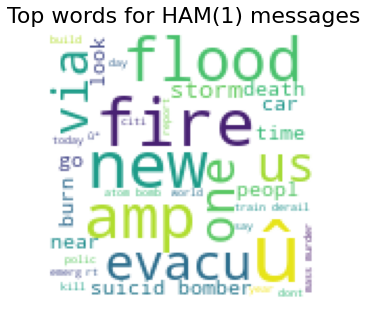

In [73]:
twitter_mask = np.array(Image.open('./asset/wordcloud_mask/twitter_mask.png'))

wc = WordCloud(
    background_color='white', 
    max_words=800, 
    mask=twitter_mask
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'text_clean']))
plt.figure(figsize=(5, 5))
plt.title('Top words for HAM(1) messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

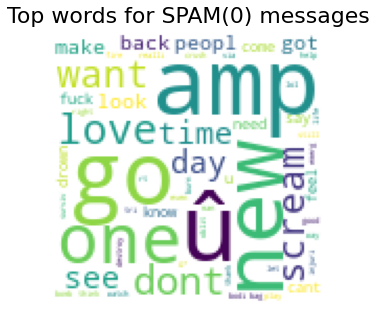

In [74]:
twitter_mask = np.array(Image.open('C:/MyStudy/06_Mini_Project/Kaggle_02_Narutal Language Processing with Disaster Tweets/asset/wordcloud_mask/twitter_mask.png'))
wc = WordCloud(
    background_color='white', 
    max_words=800, 
    mask=twitter_mask
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'text_clean']))
plt.figure(figsize=(5, 5))
plt.title('Top words for SPAM(0) messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

### 4. 벡터화

- SciKitLearn의 모델이 작동할 수 있도록 벡터로 변환  
<br>
- 1. TF(Term Frequency) 계산  
<br>
- 2. IDF(Inverse Document Frequency) 적용  
<br>
- 3. 정규화 : 벡터를 단위 길이로 정규화  
    - L2 Norm에서 추상화  
        - L2 Norm : 유클리드 좌표계

In [68]:
# CountVectorizer를 사용하기 위해 x축과 y축을 정의
x = df['text_clean']
y = df['target_encoded']

print(len(x), len(y))

7613 7613


- 트레인셋과 테스트셋 분리

In [69]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [70]:
from sklearn.feature_extraction.text import CountVectorizer

# 벡터라이저 인스턴스화
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

- 이미 훈련된 모델을 이용, 훈련 및 테스트 세트에서 문서 단어 행렬(DTM, Document-Term Matrix) 생성
    - 문서 단어 행렬(DTM, Document-Term Matrix) : 다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현

In [72]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)